1. Взять любой набор данных для бинарной классификации
2. Сделать обзорный анализ выбранного датасета
3. Обучить любой классификатор 
4. разобраться с SHAP и построить важности признаков для:
  - всего тестового набора данных (summary_plot - дать интерпретацию)
  - для 5 случайных объектов из тестового набора

_____
_____

Клиентский датасет взят [отсюда](https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset)

Ссылка на файл в [Google Drive](https://drive.google.com/drive/folders/1Dwkq0eXL_bYaL8EA3O754SwHahHBD450?usp=sharing)

## О наборе данных
### Данные банковских клиентов для прогнозирования клиентского оттока
#### Входные переменные:

- **```customer_id```** - id клиента, тип int
- **```credit_score```** - кредитный рейтинг, тип int
- **```country```** - страна, категорийный признак со значниями 'France', 'Spain', 'Germany'
- **```gender```** - пол, категорийный признак со значниями 'Female', 'Male'
- **```age```** - возраст, тип int
- **```tenure```** - сколько лет клиант пользуется продуктами банка, тип int со значениями $\in$ [1;10]
- **```balance```** - баланс клиента, тип float
- **```products_number```** - номер банковского продукта, тип int со значениями $\in$ [1;4]
- **```credit_card```** - есть ли кредитная карта, бинарный признак
- **```active_member```** - актиный ли клиент? Бинарный признак
- **```estimated_salary```** - предполагаемая зарплата, тип float

Целевая переменная:

- **```churn```** - целевая переменная: 
  - 1 = клиент в оттоке
  - 0 = клиент не в оттоке

пропусков в данных нет

In [1]:
# !pip install shap eli5

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.inspection import permutation_importance

import eli5
import shap

In [3]:
def get_metrics(y_test, preds):
    """функция возвращает значения Threshold, F-Score, Precision, Recall, ROC AUC"""
    
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    print(f'Best Threshold={thresholds[ix]:.3f}\nF-Score={fscore[ix]:.3f}\n'
          f'Precision={precision[ix]:.3f}\nRecall={recall[ix]:.3f}\n'
          f'ROC AUC={roc_auc_score(y_test, preds):.3f}')

In [4]:
df = pd.read_csv('Bank Customer Churn Prediction.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


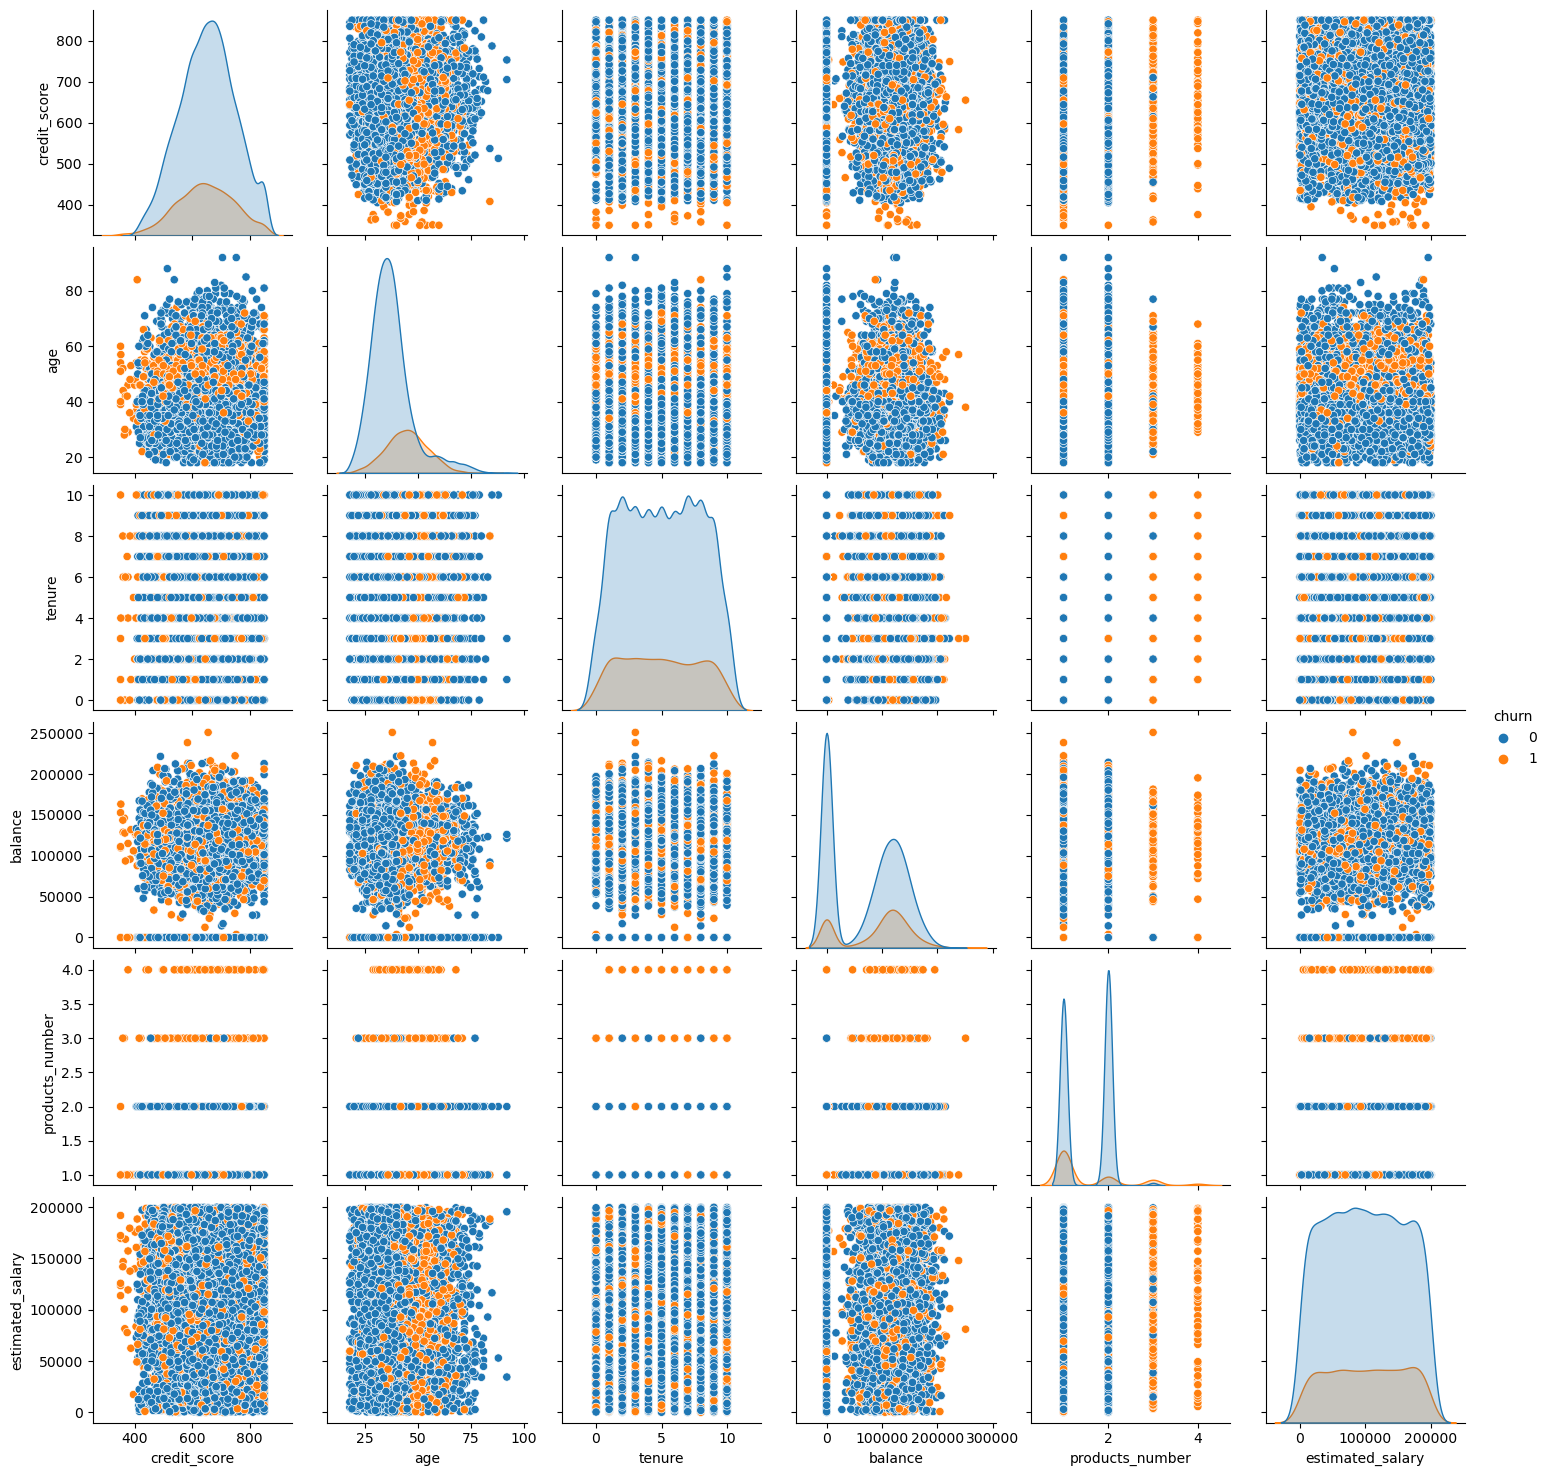

In [5]:
sns.pairplot(df, hue='churn',
             vars=['credit_score', 'age', 'tenure', 'balance', 'products_number', 'estimated_salary']);

Пока явно видно только зависимость оттока от количества продуктов, остальное - малопонятные кляксы


Немного обработаем данные перед применением модели - страну и гендер переведём в цифровой вид, а *customer_id* удалим, он в обучении не нужен:

In [6]:
cat_columns = ['country', 'gender']
dummy_df = pd.get_dummies(df[cat_columns])
df = pd.concat([df[df.columns.drop(cat_columns).tolist()], dummy_df], axis=1)

df_id = df['customer_id']
df.drop(columns='customer_id', inplace=True)

df.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


Разделим датасет:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns='churn'), df['churn'], test_size=.3, random_state=0)

Обучимся:

In [8]:
best_params = {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 
               'min_samples_split': 5, 'n_estimators': 100, 'subsample': 1.0, 'random_state': 0}
model = GradientBoostingClassifier(**best_params)
model.fit(X_train, y_train)
preds = model.predict_proba(X_test)[:, 1]
get_metrics(y_test, preds)

Best Threshold=0.283
F-Score=0.652
Precision=0.611
Recall=0.699
ROC AUC=0.880


С помощью библиотеки ```eli5``` посмотрим на важность признаков:

In [9]:
eli5.show_weights(model, feature_names=X_train.columns.tolist())

Weight,Feature
0.3847 ± 0.3947,age
0.3112 ± 0.3711,products_number
0.1017 ± 0.1578,active_member
0.0868 ± 0.5035,balance
0.0540 ± 0.2193,country_Germany
0.0285 ± 0.3583,credit_score
0.0147 ± 0.3097,estimated_salary
0.0100 ± 0.1353,gender_Female
0.0035 ± 0.1053,gender_Male
0.0027 ± 0.0833,tenure


По таблице видим, что наибольшее значение имеет возраст клиентов, выбор банковского продукта (это же показал pairplot), активность и баланс. Так же обращает на себя внимание "вес" Германии, несмотря на то, что большинство клиентов датасета - французы, что-то в Гермнии происходит важное для нас:

In [10]:
pd.read_csv('Bank Customer Churn Prediction.csv').country.value_counts()

France     5014
Germany    2509
Spain      2477
Name: country, dtype: int64

Bзучим значение признаков с помощью библиотеки ```shap```:

In [11]:
explainer = shap.TreeExplainer(model)
preds_train = model.predict_proba(X_train)[:, 1]
shap_values_all = explainer.shap_values(X_train)

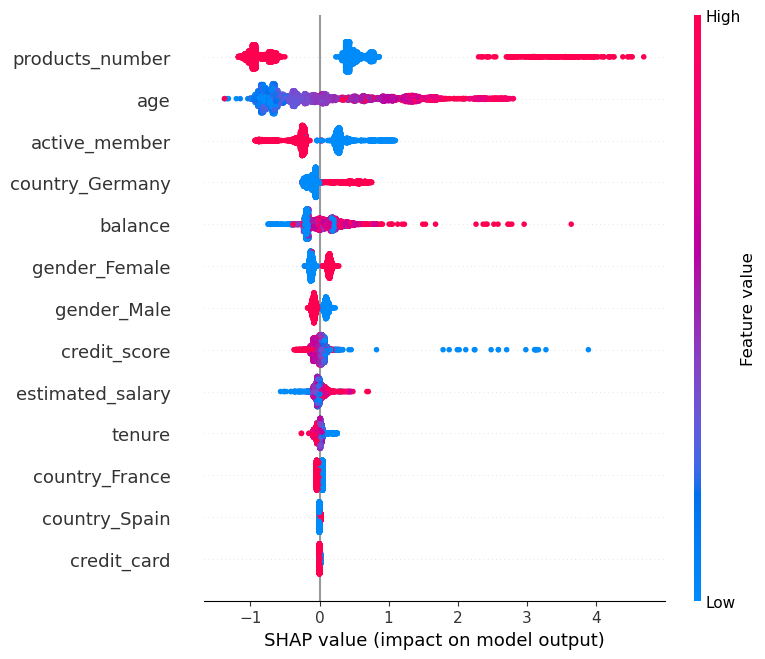

In [12]:
shap.summary_plot(shap_values_all, X_train)

А вот по ```shap``` на первое место выходит выбор банковского продукта. К сожалению, с датасетом не прилагалось подробного описания того, что же это за продукты, только их значение:

In [13]:
df.products_number.value_counts()

1    5084
2    4590
3     266
4      60
Name: products_number, dtype: int64

но по графику мы можем сделать вывод о том, что чем больше продуктов у клиента банка, тем ниже риск его оттока.

А ещё молодёжь склонна с нами оставаться, стоит обратить на неё внимание, она же, по всей видимости, самая активная аудитория, что логично. И баланс у неё ниже. А вот Германия настораживает - на графике большая склонность к оттоку, это чувствительный регион, требующий особого к себе внимания

Посмотрим на иднивидуальное влияние признаков для некоторых клиентов:

In [14]:
shap.initjs()
idx = 12
print(f'pred is {preds_train[idx]:.4f}')
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], features=X_train.iloc[idx,:])

pred is 0.0231


Молодая активная французская клиентка-девушка, пользуется двумя продуктами, можем за неё не переживать, в отток она не собирается)

In [15]:
shap.initjs()
idx = 99
print(f'pred is {preds_train[idx]:.4f}')
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], features=X_train.iloc[idx,:])

pred is 0.5548


А вот здесь тревожно - возраст средний, баланс приличный, продукт один, да ещё и Германия - клиент практически ушёл от из банка...

In [16]:
shap.initjs()
idx = 300
print(f'pred is {preds_train[idx]:.4f}')
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], features=X_train.iloc[idx,:])

pred is 0.0445


Молодой француз, активности нет, возможно, есть смысл как-то привлечь его к активности, так как мы знаем, что активные клиенты менее склонны к оттоку

In [17]:
shap.initjs()
idx = -20
print(f'pred is {preds_train[idx]:.4f}')
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], features=X_train.iloc[idx,:])

pred is 0.0785


Вот интересный клиент - возраст говорит о том, что активная девушка с хорошим балансом остётся с банком, но она использует мало продуктов, а это тянет её к оттоку

In [18]:
shap.initjs()
idx = -30
print(f'pred is {preds_train[idx]:.4f}')
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], features=X_train.iloc[idx,:])

pred is 0.0362


Молодой человек-француз, 9 лет с банком, активно использует 2 продукта, малоактивен, что немного тянет его к оттоку, но в целом клиент стабилен и надёжен.

_____

Посмотрим на итерактивную карту:

In [19]:
n=5
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_all[:n], X_train.iloc[:n])

В итоге выводы сделать можно такие:
- Крайне важно количество банковских продуктов - чем больше их использует клиент, тем крепче он "привязан" к банку и тем ниже вероятность его оттока.
- Банк привлекателен для молодёжи - молодые клиенты стабильны, но отсутствие у некоторых из них активности немного склоняет их к оттоку. Так как во многом они наша ключевая аудитория, стоит продумать отдельные кампании по стимулированию активности у молодёжи.
- Пожилые, да ещё и с балансом побольше, так  норовят сбежать. Необходимо кастомизировать банковские продукты под эту аудиторию.
- Особое внимание стоит обратить на клиентов из Германи - в этой стране с оттоком серьёзная проблема, он напоминает массовый исход - стоит проверить конкурентные предложения других банков в Германии и в целом внимательно изучить положение в регионе.